# CE265 Spring 2025
## Assignment 4

### Parse the downloaded CSV file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'Crashes.csv'
# Read with strip whitespace from column names
df = pd.read_csv(file_path, skipinitialspace=True)

# Clean column names by stripping extra whitespace
df.columns = df.columns.str.strip()

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of crashes: {len(df)}")

# Display the first few rows
df.head()


Dataset shape: (4147, 80)
Number of crashes: 4147


,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,8167836,2019,2020-01-10,103,2019-06-29,1109,45,NaN,6,5,...,0,0,-,-,37.855839,-122.262413,ALAMEDA,BERKELEY,-122.262459,37.855797
1,8167848,2019,2020-03-04,103,2019-06-19,2220,155,NaN,3,5,...,0,0,-,-,37.859112,-122.289330,ALAMEDA,BERKELEY,-122.289001,37.859459
2,8167852,2019,2020-01-08,103,2019-06-23,1805,108,40,7,5,...,0,0,-,-,NaN,NaN,ALAMEDA,BERKELEY,-122.290268,37.863396
3,8167864,2019,2019-10-10,103,2019-06-23,2329,94,24,7,5,...,0,0,-,-,37.872150,-122.268410,ALAMEDA,BERKELEY,-122.268387,37.872200
4,8465866,2019,2019-06-21,109,2019-02-22,1433,8610,2,5,5,...,0,0,-,-,NaN,NaN,ALAMEDA,OAKLAND,-122.185089,37.797760


In [2]:
# Basic statistics on the dataset
print("Counties in the dataset:")
print(df['COUNTY'].value_counts())

print("\nCities in the dataset:")
print(df['CITY'].value_counts())

# Check for missing coordinates
missing_coords = df[df['LATITUDE'].isna() | df['LONGITUDE'].isna()]
print(f"\nRecords with missing coordinates: {len(missing_coords)}")

# For records with POINT_X and POINT_Y but missing LAT/LONG
has_point_coords = missing_coords[(~missing_coords['POINT_X'].isna()) & (~missing_coords['POINT_Y'].isna())]
print(f"Records with POINT_X/Y but missing LAT/LONG: {len(has_point_coords)}")

# Create a complete dataset with available coordinates
# First copy LAT/LONG when available
df_coords = df.copy()

# Then fill missing LAT/LONG with POINT_Y/X when available
mask = df_coords['LATITUDE'].isna() & ~df_coords['POINT_Y'].isna()
df_coords.loc[mask, 'LATITUDE'] = df_coords.loc[mask, 'POINT_Y']

mask = df_coords['LONGITUDE'].isna() & ~df_coords['POINT_X'].isna()
df_coords.loc[mask, 'LONGITUDE'] = df_coords.loc[mask, 'POINT_X']

# Count remaining records with missing coordinates
still_missing = df_coords[df_coords['LATITUDE'].isna() | df_coords['LONGITUDE'].isna()]
print(f"Records still missing coordinates: {len(still_missing)}")

# Keep only records with valid coordinates
df_valid = df_coords.dropna(subset=['LATITUDE', 'LONGITUDE'])
print(f"Final dataset size with valid coordinates: {len(df_valid)}")


Counties in the dataset:
COUNTY
ALAMEDA    4147
Name: count, dtype: int64

Cities in the dataset:
CITY
OAKLAND     2662
BERKELEY    1485
Name: count, dtype: int64

Records with missing coordinates: 1857
Records with POINT_X/Y but missing LAT/LONG: 1841
Records still missing coordinates: 16
Final dataset size with valid coordinates: 4131


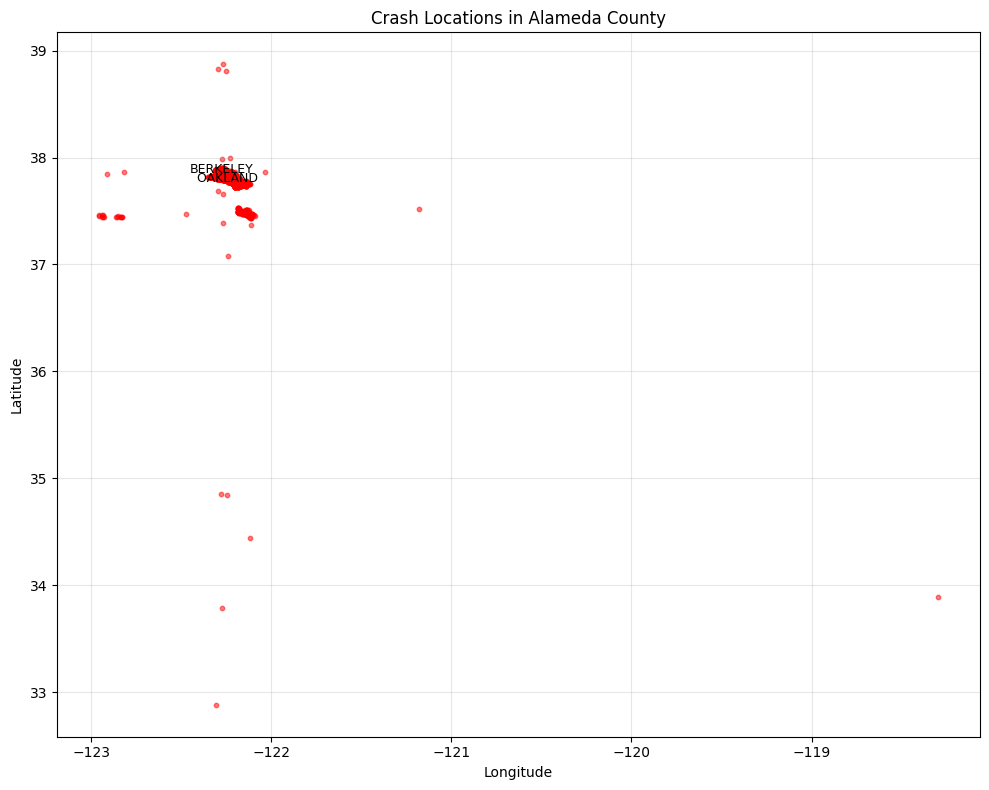

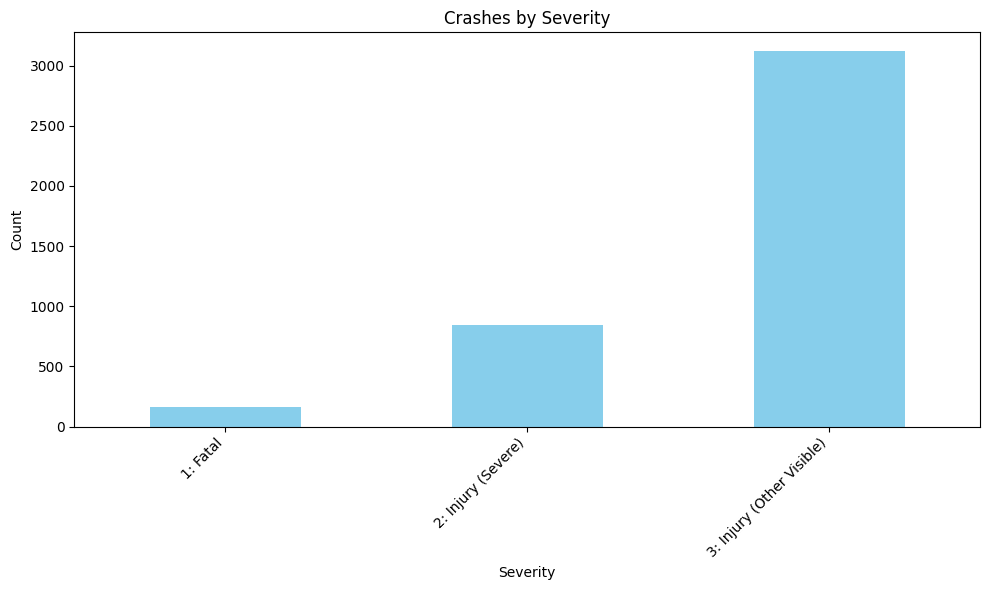

In [3]:
# Visualize crash locations
plt.figure(figsize=(10, 8))
plt.scatter(df_valid['LONGITUDE'], df_valid['LATITUDE'], c='red', alpha=0.5, s=10)
plt.title('Crash Locations in Alameda County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Add city labels for reference
cities = df_valid.groupby('CITY')[['LONGITUDE', 'LATITUDE']].mean()
for city, (lon, lat) in cities.iterrows():
    plt.annotate(city, (lon, lat), fontsize=9, ha='center')

plt.tight_layout()
plt.show()

# Count crashes by severity
severity_counts = df_valid['COLLISION_SEVERITY'].value_counts().sort_index()
severity_labels = {
    1: 'Fatal',
    2: 'Injury (Severe)',
    3: 'Injury (Other Visible)',
    4: 'Injury (Complaint of Pain)',
    0: 'Property Damage Only'
}

# Map numeric values to descriptive labels
severity_counts.index = severity_counts.index.map(lambda x: f"{x}: {severity_labels.get(x, 'Unknown')}")

plt.figure(figsize=(10, 6))
severity_counts.plot(kind='bar', color='skyblue')
plt.title('Crashes by Severity')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


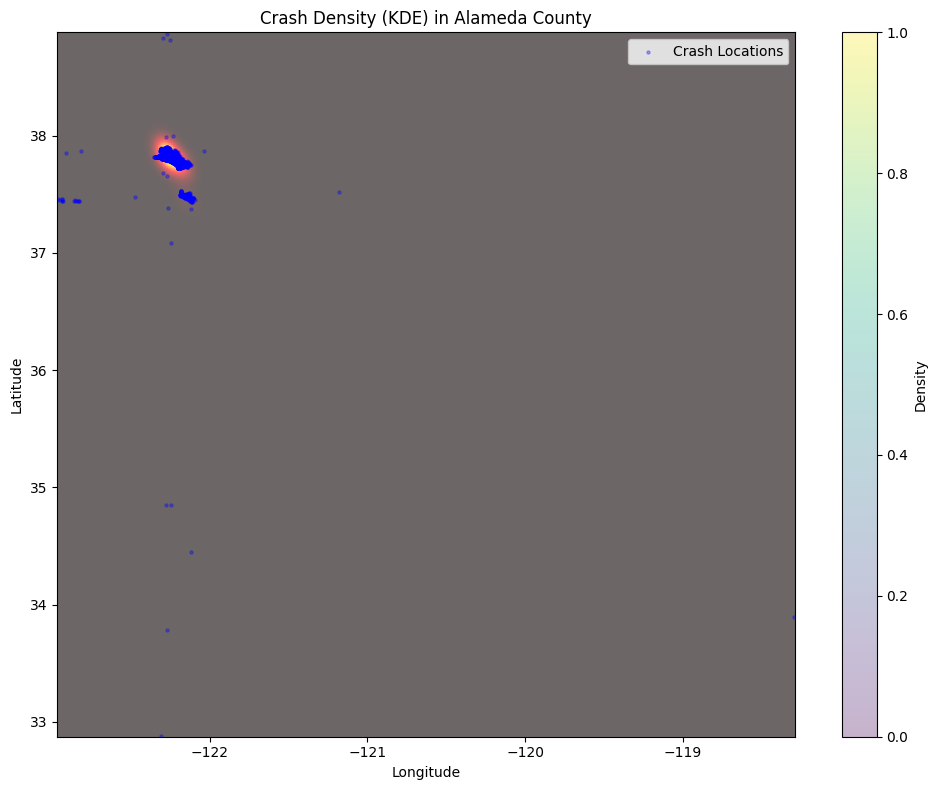

In [7]:
# Kernel Density Estimation (KDE) for crash concentrations
from scipy.stats import gaussian_kde

# Prepare data
x = df_valid['LONGITUDE'].values
y = df_valid['LATITUDE'].values

# Perform KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy, bw_method=0.5)

# Create grid for evaluation
x_min, x_max = x.min() - 0.01, x.max() + 0.01
y_min, y_max = y.min() - 0.01, y.max() + 0.01
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(positions).reshape(x_grid.shape)

# Plot KDE heatmap
plt.figure(figsize=(10, 8))
plt.imshow(density, origin='lower', aspect='auto',
           extent=[x_min, x_max, y_min, y_max], cmap='hot', alpha=0.6)
plt.scatter(x, y, c='blue', s=5, alpha=0.3, label='Crash Locations')
plt.title('Crash Density (KDE) in Alameda County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Density')
plt.legend()
plt.tight_layout()
plt.show()

### In-class example to be removed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde

def apply_kde_no_autocorrelation(crash_df, bandwidth=0.1):
    """Applies Kernel Density Estimation (KDE) to crash locations without considering autocorrelation."""
    crash_points = crash_df[['x_coord', 'y_coord']].values
    weights = np.ones(len(crash_points))  # Each crash has equal weight
    
    # Perform KDE
    kde = gaussian_kde(crash_points.T, weights=weights, bw_method=bandwidth)
    
    # Create a meshgrid for visualization
    x_min, x_max = crash_points[:, 0].min() - 1, crash_points[:, 0].max() + 1
    y_min, y_max = crash_points[:, 1].min() - 1, crash_points[:, 1].max() + 1
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_coords = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density = kde(grid_coords).reshape(x_grid.shape)
    
    # Plot the KDE heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(density, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='Reds', alpha=0.6)
    plt.colorbar(label='Crash Density')
    plt.scatter(crash_points[:, 0], crash_points[:, 1], c='blue', s=10, alpha=0.5, label='Crash Locations')
    plt.title("Kernel Density Estimation of Crashes (No Autocorrelation)")
    plt.legend()
    plt.show()






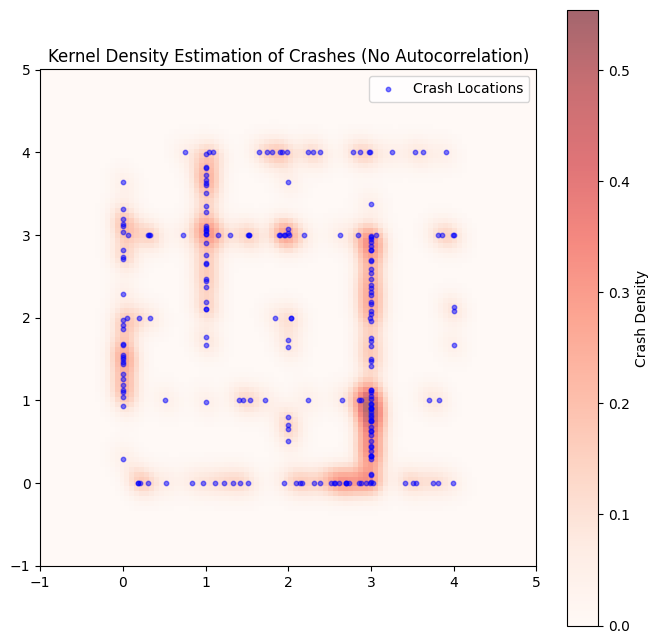

In [ ]:
# Jupyter Notebook Execution
apply_kde_no_autocorrelation(crash_data)


In [ ]:
def apply_dbscan(crash_df, eps=0.2, min_samples=3):
    """Applies DBSCAN clustering to crash locations."""
    crash_points = crash_df[['x_coord', 'y_coord']].values
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(crash_points)
    
    # Plot results
    plt.figure(figsize=(8, 8))
    unique_labels = set(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = 'black'  # Noise points
        cluster_points = crash_points[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], s=20, label=f'Cluster {label}')
    
    plt.title("DBSCAN Clustering of Crash Locations")
    plt.legend()
    plt.show()

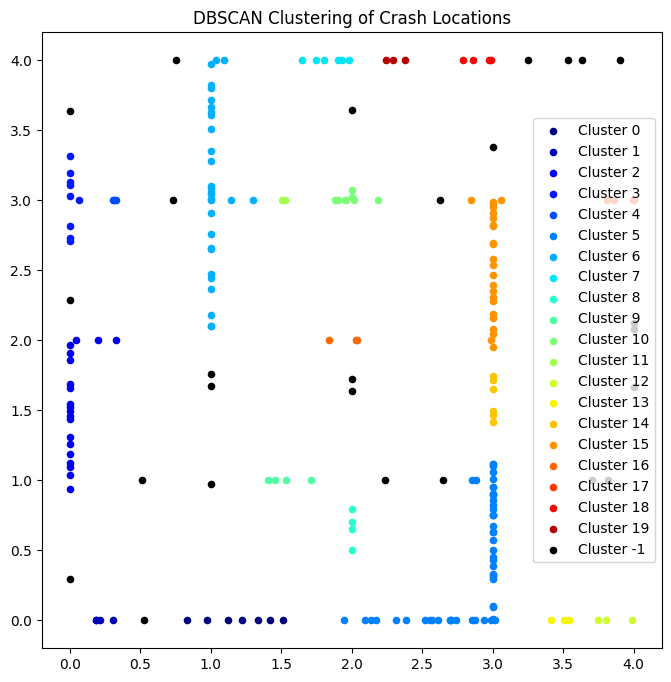

In [ ]:
apply_dbscan(crash_data)